In [1]:
import pandas as pd
import bias
%matplotlib inline

# Load the data

## Corpus metadata

In [2]:
meta = pd.read_csv("data/metadata/metadata.csv", index_col="PMID")
meta.head(1)

,DOI,KEY,SOURCE,AUTHORS,YEAR,MONTH,JOURNAL,TITLE,PAGES,VOLUME,...,NUM_COORDINATES,MNI_COORDINATES,BRAINMAP_ID,BEHAVIORAL_DOMAIN,EXPERIMENT,DESCRIPTION,IMPACT_FACTOR_2018,CITATIONS,CITATIONS_PER_YEAR,N_SUBJECTS
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,NaN,"Dolan R J, 1992",BrainMap,Dolan R J|Bench C J|Brown R G|Scott L C|Fristo...,1992,Sep,JOURNAL OF NEUROLOGY NEUROSURGERY & PSYCHIATRY,Regional cerebral blood flow abnormalities in ...,768-773,55,...,7.0,"-7.66,51.87,-8.33;-5.51,56.46,-4.28;-5.48,58.9...",6030020.0,"['Action.Rest', 'Action.Rest']","['Unimpaired > Impaired', 'Impaired > Unimpair...",Patients with depression who were cognitively ...,8.327,21,0.75,10.0


## Remove papers with missing data

In [3]:
(meta["N_SUBJECTS"] > 0).astype(int).sum() # Some papers missing data

17948

In [4]:
meta = meta.dropna(subset=["N_SUBJECTS"])
len(meta)

17948

In [5]:
pmids = meta.index
len(pmids)

17948

## Activation coordinates

In [6]:
act = pd.read_csv("data/brain/coordinates.csv", index_col=0)
act = act.loc[pmids]
act.head(1)

,left_frontal_pole,left_insular_cortex,left_superior_frontal_gyrus,left_middle_frontal_gyrus,left_inferior_frontal_gyrus_pars_triangularis,left_inferior_frontal_gyrus_pars_opercularis,left_precentral_gyrus,left_temporal_pole,left_superior_temporal_gyrus_anterior_division,left_superior_temporal_gyrus_posterior_division,...,right_caudate,right_putamen,right_pallidum,right_hippocampus,right_amygdala,right_accumbens,right_brainstem,right_cerebellar_lobules,right_cerebellar_crus,right_cerebellar_vermis
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
circuits = pd.read_csv("data/brain/clusters_data-driven_lr.csv", index_col=None)
structs = list(circuits["STRUCTURE"])
circuits.head(1)

,ORDER,CLUSTER,DOMAIN,STRUCTURE
0,1,6,MEMORY,left_amygdala


In [8]:
act_bin = (act > 0).astype(int)
act_bin = act_bin[structs]
act_bin.head()

,left_amygdala,left_hippocampus,left_inferior_temporal_gyrus_anterior_division,left_parahippocampal_gyrus_anterior_division,left_parahippocampal_gyrus_posterior_division,left_temporal_fusiform_cortex_anterior_division,right_amygdala,right_hippocampus,right_inferior_temporal_gyrus_anterior_division,right_inferior_temporal_gyrus_posterior_division,...,left_superior_temporal_gyrus_posterior_division,right_central_opercular_cortex,right_heschls_gyrus,right_middle_temporal_gyrus_anterior_division,right_middle_temporal_gyrus_posterior_division,right_parietal_operculum_cortex,right_planum_polare,right_planum_temporale,right_superior_temporal_gyrus_anterior_division,right_superior_temporal_gyrus_posterior_division
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1410086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1448149,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486459,0,0,0,0,0,0,0,0,0,1,...,1,0,0,1,1,0,0,0,1,1
1486460,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,1


## DTMs for full texts and abstracts

In [35]:
from collections import OrderedDict

In [32]:
lists = pd.read_csv("data/lexicon/lists_data-driven_lr.csv", index_col=None)
terms = lists["TOKEN"]
len(terms)

112

In [36]:
structs, colors, domains = [], [], []
for dom in OrderedDict.fromkeys(circuits["DOMAIN"]):
    dom_structs = circuits.loc[circuits["DOMAIN"] == dom, "STRUCTURE"]
    dom_structs = [struct.replace("left_", "").replace("right_", "").replace("cerebellar_crus", "cerebellum").replace("cerebellar_lobules", "cerebellum").replace("cerebellar_vermis", "cerebellum") for struct in dom_structs]
    dom_structs = list(OrderedDict.fromkeys(dom_structs))
    structs += dom_structs
    colors += [style.c[style.fw2c["data-driven"][style.order["data-driven"].index(dom)]]] * len(dom_structs)
    domains += [dom] * len(dom_structs)

In [37]:
dtm_anat_full = pd.read_csv("data/text/dtm_fulltexts_anat-syns.csv.gz", index_col=0).loc[pmids, structs]
dtm_anat_abs = pd.read_csv("data/text/dtm_abstracts_anat-syns.csv.gz", index_col=0).loc[pmids, structs]
dtm_psyc_full = pd.read_csv("data/text/dtm_fulltexts_psyc.csv.gz", index_col=0).loc[pmids, terms]
dtm_psyc_abs = pd.read_csv("data/text/dtm_abstracts_psyc.csv.gz", index_col=0).loc[pmids, terms]

In [38]:
dtm_anat_full_bin = (dtm_anat_full > 0).astype(int)
dtm_anat_abs_bin = (dtm_anat_abs > 0).astype(int)
dtm_psyc_full_bin = (dtm_psyc_full > 0).astype(int)
dtm_psyc_abs_bin = (dtm_psyc_abs > 0).astype(int)

In [39]:
dtm_psyc_abs_bin.shape

(17948, 112)

# Assess encrichment in top articles

## Compute -log(p)

In [15]:
import numpy as np

In [13]:
n = meta["N_SUBJECTS"].sort_values(ascending=False)
top_n = list(n.index[:int(len(n)/2)])
bot_n = list(n.index[int(len(n)/2):])
len(top_n)

8974

In [16]:
np.mean(meta.loc[top_n, "N_SUBJECTS"])

52.55663012408068

In [17]:
np.std(meta.loc[top_n, "N_SUBJECTS"])

99.31757952499389

In [18]:
len(bot_n)

8974

In [19]:
np.mean(meta.loc[bot_n, "N_SUBJECTS"])

12.838203771646757

In [20]:
np.std(meta.loc[bot_n, "N_SUBJECTS"])

4.0417389783846795

In [25]:
df_coord = bias.compute_bias_fdr(act_bin, circuits["DOMAIN"], top_n, "power_coord")
df_coord["STRUCTURE"] = df_coord["TERM"]
df_coord["TERM"] = [term.replace("_anterior", ",_anterior").replace("_posterior", ",_posterior").replace("heschl", "heschl'") for term in df_coord["TERM"]]
df_coord["TERM"] = [term.replace("left_", "") + " (L)" if "left_" in term else term for term in df_coord["TERM"] ]
df_coord["TERM"] = [term.replace("right_", "") + " (R)" if "right_" in term else term for term in df_coord["TERM"]]
df_coord["TERM"] = [term.replace("_", " ") for term in df_coord["TERM"]]
df_coord.sort_values("FDR").head()

,TERM,DOMAIN,P,-log10(P),FDR,ORDER,STRUCTURE
6,amygdala (R),MEMORY,1.232653e-12,11.909159,1.454531e-10,0,right_amygdala
0,amygdala (L),MEMORY,8.885942e-12,11.051297,4.149520e-10,0,left_amygdala
25,frontal medial cortex (R),REWARD,1.054963e-11,10.976763,4.149520e-10,1,right_frontal_medial_cortex
1,hippocampus (L),MEMORY,1.240914e-10,9.906258,3.660697e-09,0,left_hippocampus
28,subcallosal cortex (R),REWARD,2.133600e-09,8.670887,5.035297e-08,1,right_subcallosal_cortex


In [41]:
df_anat_full = bias.compute_bias_fdr(dtm_anat_full_bin, domains, top_n, "power_anat_full")
df_anat_abs = bias.compute_bias_fdr(dtm_anat_abs_bin, domains, top_n, "power_anat_abs")
df_psyc_full = bias.compute_bias_fdr(dtm_psyc_full_bin, lists["DOMAIN"], top_n, "power_psyc_full")
df_psyc_abs = bias.compute_bias_fdr(dtm_psyc_abs_bin, lists["DOMAIN"], top_n, "power_psyc_abs")

In [79]:
fdr_thres = 1e-5
df_anat_full_thres = df_anat_full.loc[df_anat_full["FDR"] < fdr_thres]
df_anat_abs_thres = df_anat_abs.loc[df_anat_abs["FDR"] < fdr_thres]
df_psyc_full_thres = df_psyc_full.loc[df_psyc_full["FDR"] < fdr_thres]
df_psyc_abs_thres = df_psyc_abs.loc[df_psyc_abs["FDR"] < fdr_thres]

## Plot -log(p)

In [28]:
from style import style


power_coord_brain


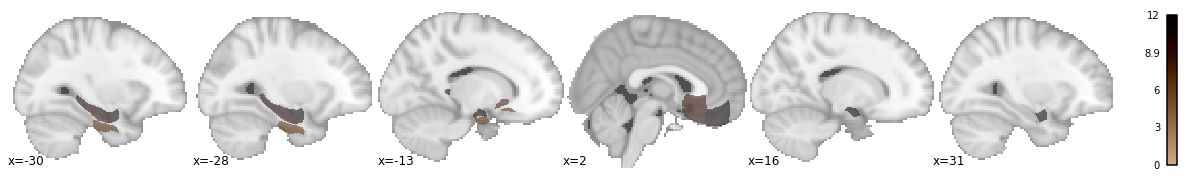


power_coord_brain


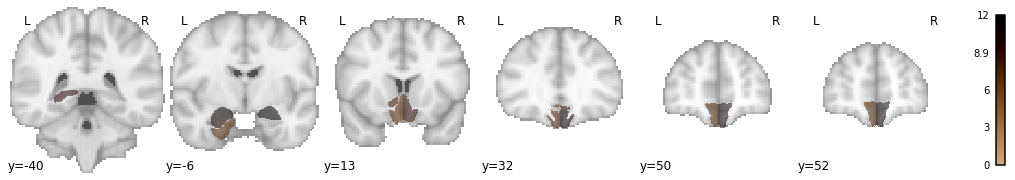


power_coord_brain


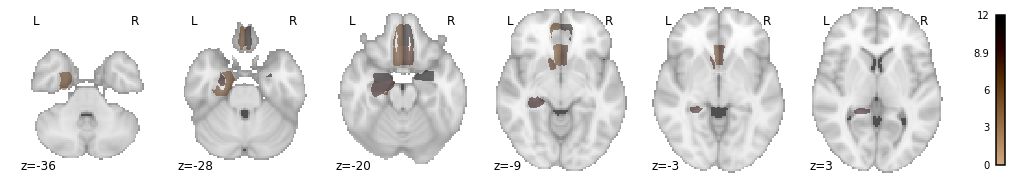

In [49]:
fdr_thres = 1e-5
df_coord_thres = df_coord.loc[df_coord["FDR"] < fdr_thres]
labs = pd.read_csv("data/brain/labels.csv")["PREPROCESSED"]
df = pd.DataFrame({"power_coord_brain": df_coord["-log10(P)"].values})
df.index = df_coord["STRUCTURE"]
df["power_coord_brain"].values[df_coord["FDR"] >= fdr_thres] = np.nan
df = df.loc[labs]
atlas = bias.load_atlas(path="data")
for plane in ["x", "y", "z"]:
    bias.map_plane(df, atlas, "figures", plane=plane, cut_coords=6, 
                   cbar=True, cmaps=[style.make_cmap(style.c["brown"])], 
                   suffix="_" + plane, print_fig=True, verbose=False)

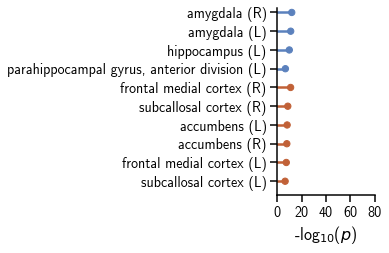

In [66]:
bias.plot_dots(df_coord_thres, "power_coord",  
               width=1.75, height=0.175*len(df_anat_full_thres) + 1, font_size=14)

/anaconda3/envs/ontol/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


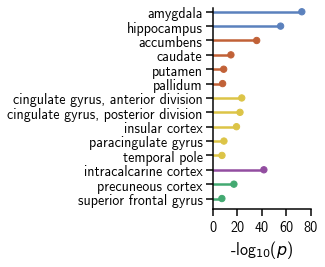

In [75]:
df_anat_full_thres["TERM"] = [term.replace("_anterior", ",_anterior").replace("_posterior", ",_posterior") for term in df_anat_full_thres["TERM"]]
bias.plot_dots(df_anat_full_thres, "power_anat_full", 
               width=1.75, height=0.175*len(df_anat_full_thres) + 1.25, font_size=14)

/anaconda3/envs/ontol/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


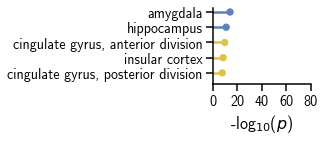

In [80]:
df_anat_abs_thres["TERM"] = [term.replace("_anterior", ",_anterior").replace("_posterior", ",_posterior") for term in df_anat_abs_thres["TERM"]]
bias.plot_dots(df_anat_abs_thres, "power_anat_abs", 
               width=1.75, height=0.1*len(df_anat_full_thres), font_size=14)

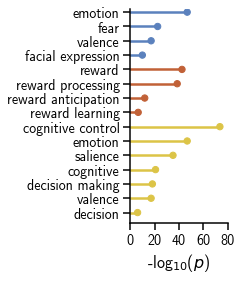

In [72]:
bias.plot_dots(df_psyc_full_thres, "power_psyc_full", 
               width=1.75, height=0.175*len(df_anat_full_thres) + 1.5, font_size=14)

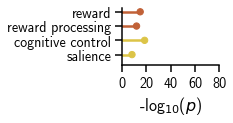

In [71]:
bias.plot_dots(df_psyc_abs_thres, "power_psyc_abs", 
               width=1.75, height=0.075*len(df_anat_full_thres), font_size=14)